## Introduction to nptsne

This Jupyter notebook provides an executable documentation for using the nptsne package. To run it install nptsne from Pypi or pip install the downloaded .whl file fo your os. 

#### Demo requirements

Nptsne is supported on python 3.6 or 3.7. The following packages are required to run this demo:

* numpy
* matplotlib
* six
* scipy
* umap-learn (for the umap examples)


In [1]:
import os
import sys
import nptsne
import matplotlib.pyplot as plt
from   matplotlib import rc
import numpy as np

from six.moves import urllib
from scipy.io import loadmat
from matplotlib import colors as mcolors
from timeit import default_timer as timer

print("Running python {}.{}".format(sys.version_info.major, sys.version_info.minor))


Running python 3.7


### <font color=blue>nptsne.TextureTsne API</font>

This class allows a basic inteface which is similar to the [scikit-learn tsne](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). This API comprises the following methods 
* `__init__`: nptsne.TextureTsne() constructor
* `fit_transform` : Create the tSNE embedding

Full API documentation will be shown in the cell below.

In [2]:
import nptsne
help(nptsne)


Help on package nptsne:

NAME
    nptsne

PACKAGE CONTENTS
    example
    version

SUBMODULES
    libs

CLASSES
    pybind11_builtins.pybind11_object(builtins.object)
        nptsne.libs._nptsne.KnnAlgorithm
        nptsne.libs._nptsne.TextureTsne
        nptsne.libs._nptsne.TextureTsneExtended
    
    class KnnAlgorithm(pybind11_builtins.pybind11_object)
     |  Method resolution order:
     |      KnnAlgorithm
     |      pybind11_builtins.pybind11_object
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __eq__(...)
     |      __eq__(self: nptsne.libs._nptsne.KnnAlgorithm, arg0: nptsne.libs._nptsne.KnnAlgorithm) -> bool
     |  
     |  __ge__(...)
     |      __ge__(self: nptsne.libs._nptsne.KnnAlgorithm, arg0: nptsne.libs._nptsne.KnnAlgorithm) -> bool
     |  
     |  __getstate__(...)
     |      __getstate__(self: nptsne.libs._nptsne.KnnAlgorithm) -> tuple
     |  
     |  __gt__(...)
     |      __gt__(self: nptsne.libs._nptsne.KnnAlgorithm, 

In [3]:
from nptsne import KnnAlgorithm
help(KnnAlgorithm)

Help on class KnnAlgorithm in module nptsne.libs._nptsne:

class KnnAlgorithm(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      KnnAlgorithm
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __eq__(...)
 |      __eq__(self: nptsne.libs._nptsne.KnnAlgorithm, arg0: nptsne.libs._nptsne.KnnAlgorithm) -> bool
 |  
 |  __ge__(...)
 |      __ge__(self: nptsne.libs._nptsne.KnnAlgorithm, arg0: nptsne.libs._nptsne.KnnAlgorithm) -> bool
 |  
 |  __getstate__(...)
 |      __getstate__(self: nptsne.libs._nptsne.KnnAlgorithm) -> tuple
 |  
 |  __gt__(...)
 |      __gt__(self: nptsne.libs._nptsne.KnnAlgorithm, arg0: nptsne.libs._nptsne.KnnAlgorithm) -> bool
 |  
 |  __hash__(...)
 |      __hash__(self: nptsne.libs._nptsne.KnnAlgorithm) -> int
 |  
 |  __init__(...)
 |      __init__(self: nptsne.libs._nptsne.KnnAlgorithm, arg0: int) -> None
 |  
 |  __int__(...)
 |      __int__(self: nptsne.libs._nptsne.KnnAlgorithm) -> int


#### <font color=blue>Download minist data for use in the demos</font>

In [4]:
mnist_path = 'mnist-original.mat'
if not os.path.isfile(mnist_path):
    mnist_alternative_url = 'https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat'
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, 'wb') as f:
        content = response.read()
        f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    'data': mnist_raw['data'].T,
    'label': mnist_raw['label'][0],
    'COL_NAMES': ['label', 'data']
}
print('Mnist data dimenstions: ', mnist['data'].shape)


Mnist data dimenstions:  (70000, 784)


#### <font color=blue>Create a tSNE embedding of the 70000 MNIST data points & display the elapsed time</font>

In [5]:
tsne = nptsne.TextureTsne(False,1000,2,30,800, nptsne.KnnAlgorithm.Flann)
#Can also be run with knn as HNSW: this works faster in very large datasets lower dimensional data (<40 dimensions)
#tsne = nptsne.TextureTsne(False,1000,2,30,800, nptsne.nptsne.KnnAlgorithm.HNSW)

embedding = None
try:
   
    for i in range(1):
        start = timer()
        embedding = tsne.fit_transform(mnist['data'])
        end = timer()
        print(f'got embedding in {end - start}')
except Exception as ex:
    print('Error....')
    print(ex)

got embedding in 28.4102499


#### <font color=blue>DIsplay the tSNE Mnist embedding</font>

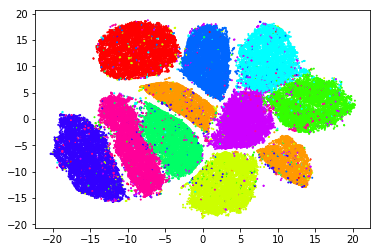

In [6]:
colors = ['#FF0000', '#FF9900', '#CCFF00', '#33FF00', '#00FF66', '#00FFFF', '#0066FF', '#3300FF', '#CC00FF', '#FF0099']
# norm = mcolors.Normalize(vmin=0, vmax=9)
xyembed = embedding.reshape((70000, 2))
# mcolors.ListedColormap(colors)
rc('lines', linewidth=2)
rc('lines', markersize=1)
plt.scatter(xyembed[..., 0], xyembed[..., 1], c=mnist['label'], cmap=mcolors.ListedColormap(colors), facecolors='None', marker='o')
plt.show()

### <font color=blue>nptsne.TextureTsneExtended API</font>

This class offers a second, more flexible API. It adds a number of features to the basic TextureTsne API, specifically:

* `__init`: nptsne.TextureTsneExtended() constructor.
* `init_transform`: Initialize the transform with data and an optional initial embedding.  Performs the nearest neighbor calculation
* `run_transform`: Running/restarting the transform for a number or iterations (enables display of intermediate results). Enable/disable verbose output. 
* `start_exaggeration_decay`: Explicitly triggering the force exaggeration decay. Permits the typical tSNE cluster expansion. In the basic API this occurs at 250 iterations.
* `close`: Free the GPU resources.

Properties
* `decay_started_at`: The iteration number when decay exaggeration was started.
* `iteration_count`: The current iteration.

Full API documentation will be shown in the cell below.

In [7]:
print("nptsne version: {}".format(nptsne.__version__))
help(nptsne.TextureTsneExtended)

nptsne version: 1.0.0rc2
Help on class TextureTsneExtended in module nptsne.libs._nptsne:

class TextureTsneExtended(pybind11_builtins.pybind11_object)
 |  TextureTsneExtended: an advanced wrapper API for the linear tSNE implementation.
 |  
 |  TextureTsneExtended offers additional control over the exaggeration decay
 |     along with the ability to input an initial embedding.
 |     Based on the linear tSNE algorithm described in doi://
 |  
 |  Method resolution order:
 |      TextureTsneExtended
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: nptsne.libs._nptsne.TextureTsneExtended, verbose: bool=False, num_target_dimensions: int=2, perplexity: int=30, knn_algorithm: nptsne.libs._nptsne.KnnAlgorithm=KnnAlgorithm.Flann) -> None
 |      
 |      
 |      Args:
 |          verbose (bool): Enable verbose logging to std::out
 |      
 |          num_target_dimensions (int): The number of dimen

#### <font color=blue>Create and initialize TextureTsneExtended with Mnist data</font>

In [8]:
tsne = nptsne.TextureTsneExtended(False)
embeddings = []
if tsne.init_transform(mnist['data']):
    print('Init succeeded')

Init succeeded


#### <font color=blue>Run the tSNE embedding in blocks of 100 iterations. Reduce the exaggeration force from step 700. Record the intermediate embeddings in a plot.</font>

got embedding in 3.7560246999999976
iteration count 100
subplot 1
got embedding in 0.18796269999999993
iteration count 200
subplot 2
got embedding in 0.20409439999998824
iteration count 300
subplot 3
got embedding in 0.19188320000000658
iteration count 400
subplot 4
got embedding in 0.18706160000000693
iteration count 500
subplot 5
got embedding in 0.18237260000000788
iteration count 600
subplot 6
got embedding in 0.19699599999999862
iteration count 700
subplot 7
exaggeration stopping at 700
got embedding in 0.21938519999999073
iteration count 800
subplot 8
got embedding in 0.2961077000000074
iteration count 900
subplot 9
got embedding in 0.42788539999999387
iteration count 1000
subplot 10


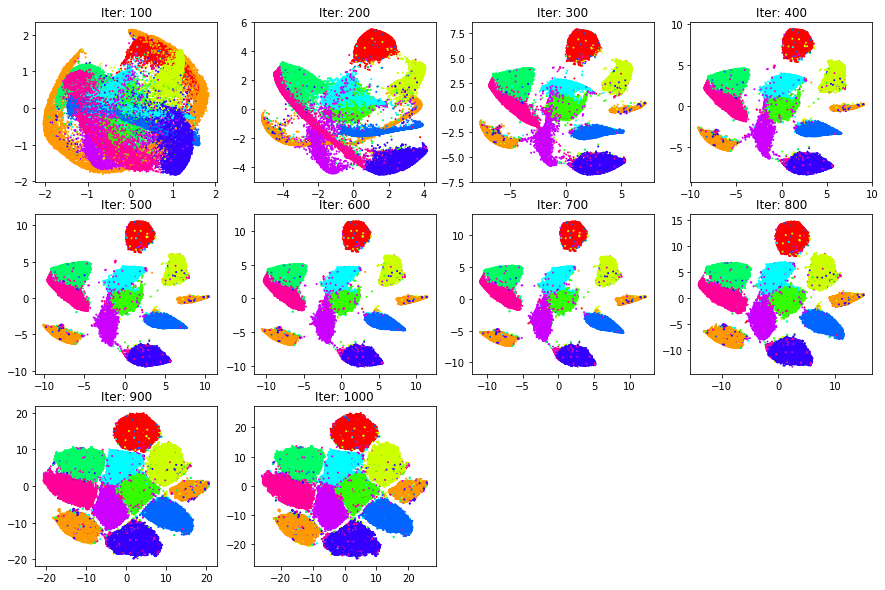

In [9]:
step_size = 100
plt.figure(2,figsize=(15,10))

for i in range(10):
    
    start = timer()
    stop_exaggeration = False
    # reduce the forces from iteration 700 
    if i == 7:
        tsne.start_exaggeration_decay()
        print(f'exaggeration stopping at {tsne.decay_started_at}')
    embedding = tsne.run_transform(verbose=False, iterations=step_size)
    end = timer()
    print(f'got embedding in {end - start}')
    print(f'iteration count {tsne.iteration_count}')
    xyembed = np.copy(embedding.reshape((70000, 2)))
    embeddings.append(xyembed)
    print(f"subplot {i+1}")
    plt.subplot(3,4,i+1)
    plt.gca().set_title('Iter: ' + str(100*(i+1)))
    plt.scatter(xyembed[..., 0], xyembed[..., 1], c=mnist['label'], cmap=mcolors.ListedColormap(colors), facecolors='None', marker='o')

plt.draw()
plt.savefig(f'testext.png')
   

tsne.close() 


#### <font color=blue>Reset the embedding and rerun the transform above (this does not rerun the knn so the speed is maximum</font>

got embedding in 0.7300616999999932


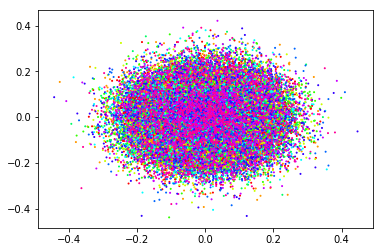

In [11]:
tsne.reinitialize_transform()
start = timer()
tsne.run_transform(verbose=True, iterations=250)
tsne.start_exaggeration_decay()
embedding = tsne.run_transform(verbose=True, iterations=750)
end = timer()
print(f'got embedding in {end - start}')
xyembed = np.copy(embedding.reshape((70000, 2)))
embeddings.append(xyembed)
plt.scatter(xyembed[..., 0], xyembed[..., 1], c=mnist['label'], cmap=mcolors.ListedColormap(colors), facecolors='None', marker='o')
plt.show()

#### <font color=blue>Make a umap embedding of a randompy selected 1/10 of the Mnist data.</font>

(6983,) (6983, 784)


/home/bvanlew/anaconda3/envs/py36test/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../anaconda3/envs/py36test/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/bvanlew/anaconda3/envs/py36test/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../anaconda3/envs/py36te

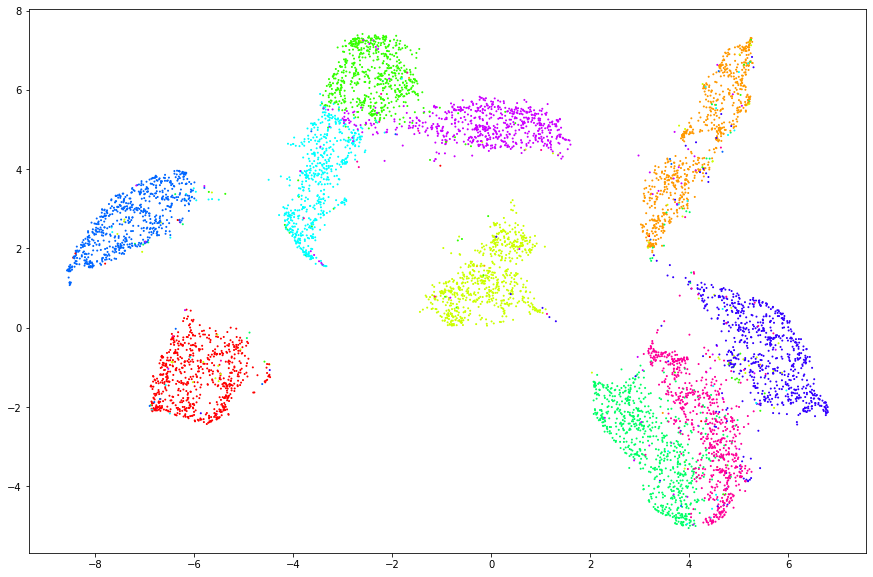

In [12]:
# extract 1 data point in 10  : p=[.1, .9]
# generate and index array with approximately 1/10 of data row numbers
import umap
idx = np.where(np.random.choice([1, 0], size=70000, p=[0.1, 0.9]))
subLabel = np.squeeze(mnist['label'][idx])
subData =  mnist['data'][idx]

print(subLabel.shape, subData.shape)

umap_embed = umap.UMAP().fit_transform(subData)

plt.figure(3,figsize=(15,10))

plt.scatter(umap_embed[..., 0], umap_embed[..., 1], c=subLabel, cmap=mcolors.ListedColormap(colors), facecolors='None', marker='o')
plt.draw()


#### <font color=blue>Use the umap embedding to initialize the TextureTsneExtended. This shows that with high exaggeration forces tSNE leaves the umap embedding largely unchanged. Allowing the exaggeration forces to decay produced a more typical tSNE embedding.</font>

Init tSNE from umap, shape: (6983, 2)
Init from umap succeeded
got embedding in 0.31606217101216316
got embedding in 0.038488990016048774
got embedding in 0.03664382398710586
got embedding in 0.03779974899953231
got embedding in 0.034850488998927176
exaggeration stopping at 500
got embedding in 0.04442908798228018
got embedding in 0.07906753101269715
got embedding in 0.10712791499099694
got embedding in 0.13012393700773828
got embedding in 0.14947258098982275


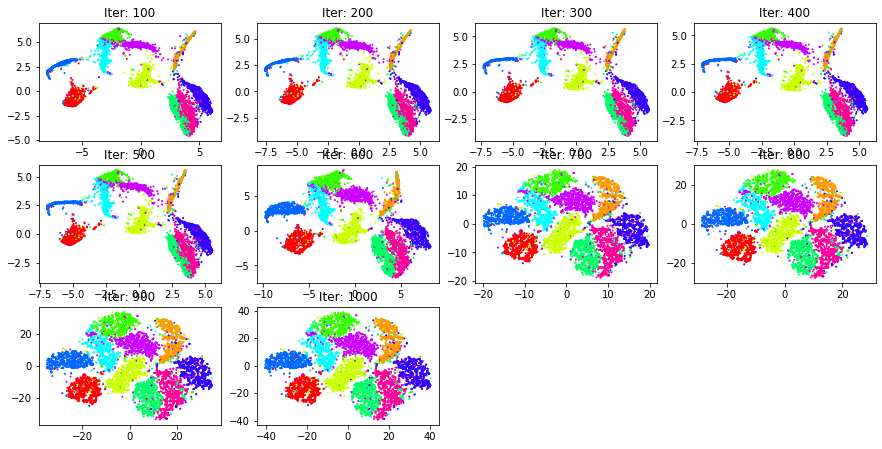

In [14]:
tsne = nptsne.TextureTsneExtended(verbose=True)

print(f'Init tSNE from umap, shape: {umap_embed.shape}')
if tsne.init_transform(subData, umap_embed):
    print('Init from umap succeeded')

step_size = 100
plt.figure(4,figsize=(15,10))
for i in range(10):
    start = timer()
    exaggeration_iter = 100
    # reduce the forces from 1000 
    if i == 5:
        tsne.start_exaggeration_decay()
        print(f'exaggeration stopping at {tsne.decay_started_at}')

    embedding = tsne.run_transform(verbose=True, iterations=step_size)
    end = timer()
    print(f'got embedding in {end - start}')
    xyembed = np.copy(embedding.reshape((-1, 2)))
    plt.subplot(4,4,i+1)
    plt.gca().set_title('Iter: ' + str(100*(i+1)))
    plt.scatter(xyembed[..., 0], xyembed[..., 1], c=subLabel, cmap=mcolors.ListedColormap(colors), facecolors='None', marker='o')

plt.draw()

tsne.close()  
